# 📝 NLP: Understanding and Generating Text with Language Models

## Overview

We will cover:
* Modern LLM APIs and how to apply them from code. We will discuss their capabilities and limitations
* Small Language Models (SLMs): how to run the language model right in the Google Colab and use cases where they are effective
* Vision-Language Models (VLMs): modern architectures and the image narration example


## Large Language Models APIs

#### Basics

- **Chat completions**: common chatgpt-like interactions.
- **System prompts**: set to control assistant's behavior. Should be treated as instructions that persist across the conversation.
- **Multi-turn conversations**. API is stateless: you need to send the full conversation history to maintain context.

In [2]:
import os
from pathlib import Path

from openai import OpenAI


api_key = Path(os.getcwd()).joinpath("./api_keys/.openai").read_text().strip()
client = OpenAI(api_key=api_key)

In [24]:
response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "user", "content": "What is machine learning in one sentence?"}
    ]
)

print(response.choices[0].message.content)

Machine learning is a branch of artificial intelligence that involves the development of algorithms and statistical models enabling computers to improve their performance on a task through experience and data.


**Composing a simple conversation:**

In [26]:
conversation = [
    {"role": "system", "content": "You are a helpful math tutor."},
    {"role": "user", "content": "What is 15 * 7?"},
]


response1 = client.chat.completions.create(
    model="gpt-4o",
    messages=conversation
)

print(f"User: {conversation[-1]['content']}")
print(f"Assistant: {response1.choices[0].message.content}")


User: What is 15 * 7?
Assistant: 15 multiplied by 7 is 105.


In [27]:
# Add the assistant's response to the conversation
conversation.append({
    "role": "assistant",
    "content": response1.choices[0].message.content
})

# Continue the conversation
conversation.append({
    "role": "user",
    "content": "Now divide that by 3"
})

In [28]:
response2 = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=conversation
)

print(f"User: {conversation[-1]['content']}")
print(f"Assistant: {response2.choices[0].message.content}")


User: Now divide that by 3
Assistant: 105 divided by 3 is 35.


#### Sampling parameters

**temperature**. Controls the randomness of predictions by scaling the probability distribution:

- Zero temperature: deterministic (greedy) sampling.
- Low temperature (0.1-0.3): Focused, conservative, factual
- High temperature (0.7-1.0): Creative, natural

**top-p (nucleus sampling)**. Selects from the smallest set of tokens whose cumulative probability exceeds p.

Example: If top_p = 0.9 and we have the conditional probabilities for the next token:
- "blue" (60%)
- "clear" (20%)
- "beautiful" (10%)
- "gray" (5%)

We'd consider only "blue", "clear", and "beautiful" (totaling 90%).

**top-k sampling**. OpenAI's API doesn't directly expose top_k parameter, but it's important to understand as it's used in many other LLM APIs (like Anthropic, Google, open-source models).

Example: If top_k = 3 and we have the conditional probabilities for the next token:
- "blue" (60%)
- "clear" (20%)
- "beautiful" (10%)
- "gray" (5%)

We'd only consider "blue", "clear", and "beautiful" (the top 3).

#### Example: Machine Translation via system prompt specification

In [11]:
import os

EN_TO_SR_TRANSLATION_PROMPT = """You are a professional English to Serbian translator. 
Your task is to translate English text into Serbian accurately and naturally.

Rules:
- Translate the given English text to Serbian
- Maintain the tone and style of the original text
- Use natural Serbian expressions where appropriate
- Only output the translated text, nothing else
- Do not add explanations or notes"""


class EnglishToSerbianTranslator:
    def __init__(self, api_key=None):
        assert api_key is not None, "API key must be provided"
        self.client = OpenAI(api_key=api_key)
        self.model = "gpt-5"
        self.max_completion_tokens = 512
        self.system_prompt = EN_TO_SR_TRANSLATION_PROMPT

    def run(self, user_input):
        try:
            response = self.client.chat.completions.create(
                model=self.model,
                max_completion_tokens=self.max_completion_tokens,
                messages=[
                    {
                        "role": "system",
                        "content": self.system_prompt
                    },
                    {
                        "role": "user",
                        "content": user_input
                    }
                ]
            )
            translated_text = response.choices[0].message.content
            return translated_text
        except Exception as e:
            return f"Error during translation: {str(e)}"

In [12]:
translator = EnglishToSerbianTranslator(api_key=api_key)

In [13]:
translator.run("Hello, how are you doing?")

'Zdravo, kako si?'

In [14]:
translator.run("What's the capital of Serbia?")

'Koji je glavni grad Srbije?'

#### Tricky examples

In [16]:
client = OpenAI(api_key=api_key)

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "user", "content": "How many Rs are in the word 'strawberry'?"}
    ]
)

print(response.choices[0].message.content)

The word "strawberry" contains 2 Rs.


*Why?*

In the "strawberry" example, the model is unable to correctly count the 'R's because it is not processing the individual letters. It is simply processing the sequence of 3 token IDs (496, 675, 15717).

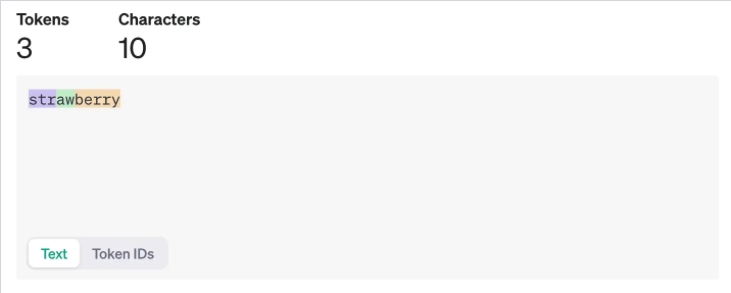

In [17]:
from IPython.display import Image
Image(filename="attachments/Strawberries-Tokenization.png", width=600)

### Practical Production Concerns

**Token counting and cost estimation**. To estimate the costs properly, we need to know:
- How many API calls per day/week?
- Typical input/output length?
- See per-token models' prices

*Example*: we have a "homework helper" app with 100 daily users. It serves 20 questions / user per day. In total, we have => 60,000 questions / month. Average input size = 100 tokens, output size = 150 tokens. <br>
Input processing price: 1.25 * 6 = 7.5 <br>
Output processing price: 10 * 7.5 = 75 <br>
Total price: $82.5 / month.



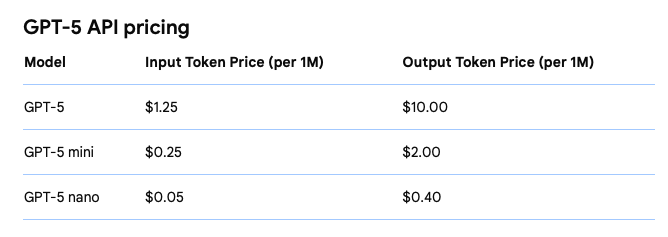

In [5]:
Image(filename="attachments/GPT-5-api-pricing.png", width=600)

Other practical concerns for LLM API apps:

**Streaming responses**. In many use cases we are interested to see the continuous generation rather than retrieving outputs after the generation is completed.

**Async / Concurrent requests**. Batch processing helps to reduce costs.

**Rate limiting**. There should be the upper bound on the number of requests sent from the clients per hour / day / week.

## Running Small Language Models (SLMs) Locally

Key differences:

| Aspect | SLMs | LLMs |
|:-------|:-----|:-----|
| **Size** | 0.5B - 7B parameters | 7B - 405B+ parameters |
| **Memory** | 1-14 GB | 14-810+ GB |
| **Speed** | Fast (local inference) | Slower (API/large hardware) |
| **Cost** | Free/low (run locally) | API costs per token |
| **Capabilities** | Good for focused tasks | Better at complex reasoning |
| **Deployment** | Edge devices, mobile | Cloud/high-end servers |


#### Models selection and loading

1. **Llama 3.2** (Meta)
   - 1B and 3B variants
   - Excellent instruction following
   - Good balance of quality and speed

2. **Qwen 2.5** (Alibaba)
   - 0.5B, 1.5B, 3B, 7B variants
   - Strong multilingual support
   - Good code generation

3. **Phi-3.5** (Microsoft)
   - Mini (3.8B) and Small (7B)
   - High quality despite small size
   - Trained on synthetic data

In [2]:
MODEL_CONFIGS = {
    "llama-3.2-3b": "meta-llama/Llama-3.2-3B-Instruct",
    "qwen-1.5b": "Qwen/Qwen2.5-1.5B-Instruct",
    "phi-3.5-mini": "microsoft/Phi-3.5-mini-instruct",
}

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

SELECTED_MODEL = "qwen-1.5b"
model_name = MODEL_CONFIGS[SELECTED_MODEL]

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    trust_remote_code=True
)

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

In [ ]:
def generate_text(
    prompt: str,
    max_new_tokens: int = 512,
    temperature: float = 0.7,
    top_p: float = 0.9,
    system_message: str = "You are a helpful AI assistant."
) -> Tuple[str, float]:
    """
    Generate text using the loaded model.
    
    Returns:
        Tuple of (generated_text, inference_time_seconds)
    """
    # Format prompt based on model
    if "llama" in SELECTED_MODEL.lower():
        messages = [
            {"role": "system", "content": system_message},
            {"role": "user", "content": prompt}
        ]
        formatted_prompt = tokenizer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
    elif "qwen" in SELECTED_MODEL.lower():
        messages = [
            {"role": "system", "content": system_message},
            {"role": "user", "content": prompt}
        ]
        formatted_prompt = tokenizer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
    elif "phi" in SELECTED_MODEL.lower():
        messages = [
            {"role": "system", "content": system_message},
            {"role": "user", "content": prompt}
        ]
        formatted_prompt = tokenizer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
    else:
        formatted_prompt = prompt
    
    # Tokenize
    inputs = tokenizer(formatted_prompt, return_tensors="pt").to(model.device)
    
    # Generate
    start_time = time.time()
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_p=top_p,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )
    inference_time = time.time() - start_time
    
    # Decode
    generated_text = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
    
    return generated_text, inference_time

In [ ]:
prompt = "Write a short poem about the beauty of autumn leaves falling in a forest."

generated_poem, inference_time = generate_text(
    prompt=prompt,
    max_new_tokens=256,
    temperature=0.8,  # Higher temperature for more creative output
    top_p=0.95,
    system_message="You are a talented poet known for vivid imagery and emotional depth."
)

print("=== POETRY GENERATION EXAMPLE ===\n")
print(f"📝 Prompt: {prompt}\n")
print(f"🎨 Generated Poem:\n{generated_poem}\n")
print(f"⏱️ Inference Time: {inference_time:.2f}s")

#### Use cases

**Summarization**.

In [ ]:
def summarize_document(doc: str, length: str = "medium") -> dict:
    length_instructions = {
        "short": "in 1-2 concise sentences",
        "medium": "in 3-4 sentences",
        "long": "in a detailed paragraph"
    }
    max_tokens = {
        "short": 100,
        "medium": 150,
        "long": 300
    }
    prompt = f"""Summarize the following text {length_instructions[length]}:

{doc}

Summary:"""
    summary, time_taken = generate_text(
        prompt, 
        max_new_tokens=max_tokens[length],
        temperature=0.3,  # Lower temperature for more focused summaries
        system_message="You are an expert at creating clear, accurate summaries."
    )
    return {
        "summary": summary.strip(),
        "time": time_taken,
        "length": length
    }


In [1]:
import time

sample_document = """
Coral reefs are among the most biodiverse ecosystems on Earth, supporting approximately 
25% of all marine species despite covering less than 1% of the ocean floor. These underwater 
structures are built by tiny colonial animals called coral polyps that form symbiotic relationships 
with zooxanthellae, photosynthetic algae living within their tissues. The algae provide energy 
through photosynthesis while corals provide protection and access to sunlight. Sadly, coral reefs 
face unprecedented threats from climate change, ocean acidification, pollution, and overfishing. 
Rising sea temperatures cause coral bleaching, where stressed corals expel their algal partners, 
often leading to death. Conservation efforts including marine protected areas, sustainable fishing 
practices, and climate action are critical to preserve these vital ecosystems for future generations.
"""

print("=== SUMMARIZATION EXAMPLES ===\n")

for length in ["short", "medium", "long"]:
    result = summarize_document(sample_document, length=length)
    print(f"📌 Length: {length.upper()}")
    print(f"Summary: {result['summary']}")
    print(f"⏱️ Time: {result['time']:.2f}s\n")

=== SUMMARIZATION EXAMPLES ===



NameError: name 'summarize_document' is not defined

**Paraphrasing**.

In [ ]:
def paraphrase_text(text: str, style: str = "neutral") -> dict:
    style_instructions = {
        "formal": "Rewrite this in a formal, professional tone",
        "casual": "Rewrite this in a casual, conversational tone",
        "neutral": "Paraphrase this while maintaining a neutral tone",
        "technical": "Rewrite this using more technical and precise terminology"
    }
    prompt = f"""{style_instructions[style]}:

Original: {text}

Rewritten version:"""
    paraphrase, time_taken = generate_text(
        prompt,
        max_new_tokens=200,
        temperature=0.7,
        system_message="You are an expert at rewriting and paraphrasing text."
    )
    return {
        "original": text,
        "paraphrase": paraphrase.strip(),
        "style": style,
        "time": time_taken
    }

In [ ]:
original_text = "The intricate web of interdependencies between organisms shapes the delicate balance of nature."

print("=== PARAPHRASING EXAMPLES ===\n")

for style in ["neutral", "formal", "casual", "technical"]:
    result = paraphrase_text(original_text, style=style)
    print(f"🎯 Style: {style.upper()}")
    print(f"Original: {result['original']}")
    print(f"Paraphrased: {result['paraphrase']}")
    print(f"⏱️ Time: {result['time']:.2f}s\n")

## Image Captioning with Vision-Language Models (VLMs)

In [ ]:
Image(filename="attachments/Skiing-In-Alpes-Poster.png", width=600)